# Gamma hedging of a spread options

Consider a market model with two assets, a Bank account and a 2 Stocks with risk neutral dynamics:

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS_1(t) = r S_1(t) dt + \sigma_1 S_1(t) dW_1(t), \hspace{10mm} S_1(0) = s_1 > 0 \\
dS_2(t) = r S_2(t) dt + \sigma_2 S_2(t) dW_2(t), \hspace{10mm} S_2(0) = s_2 > 0
$$

where $\sigma_1, \sigma_2 > 0$ and where $E[dW_1(t) dW_2(t)] = \rho dt$ is the correlation between the two Brownian motions.

Consider a spread option with that at time $T$ pays $X = (S_2(T) - S_1(T))^+$.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$. 


## Margrabe formula for princing the spread option

In the case where the strike price of a spread option is 0 ($K = 0$), there is a closed-form for pricing a spread option the Margrabe formula:

$$
p = x_2 N(d_1) - x_1 N(d_2)
$$

where 

$$
d_{1, 2} = \frac{\ln(x_2 / x_1)}{\sigma \sqrt{T}} \pm \frac{1}{2} \sigma \sqrt{T}
$$

and 

$$
x_1 = S_1(0), x_2 = S_2(0), \hspace{10mm} \sigma^2 = \sigma_1^2 + \sigma_2^2 - 2 \rho \sigma_1 \sigma_2
$$

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Example with just 1 simulation

Let's analyze the case where we hedge just the initial gamma and then delta hedge the claim at every time step

In [3]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

import jax
from jax import vmap

from jaxfin.models.gbm import MultiGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european, gamma_european

from src.spread import margrabe_deltas, margrabe_gammas, margrabe, margrabe_cross_gamma
from src.experimental.auto_diff_greeks import bs_gamma, bs_delta
import scienceplots
plt.style.use(['science','no-latex'])

SEED = 42

### Parameters

$S_1(0) = 100$

$S_2(0) = 100$

$r = 0$

$\sigma_1 = 0.2, \sigma_2 = 0.3$

$\rho = 0.2$

$T = 1$


In [4]:
s0 = jnp.array([100, 100])
means = jnp.array([0.0, 0.0])
vols = jnp.array([0.2, 0.3])
correlation = jnp.array([[1, 0.2], [0.2, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)

In [5]:
expiration = 1.0
expiration_1 = 1.1
N = 252
dt = expiration / N
n_simulation = 1

stock_path = gbm.simulate_paths(SEED, expiration, N, n_simulation)

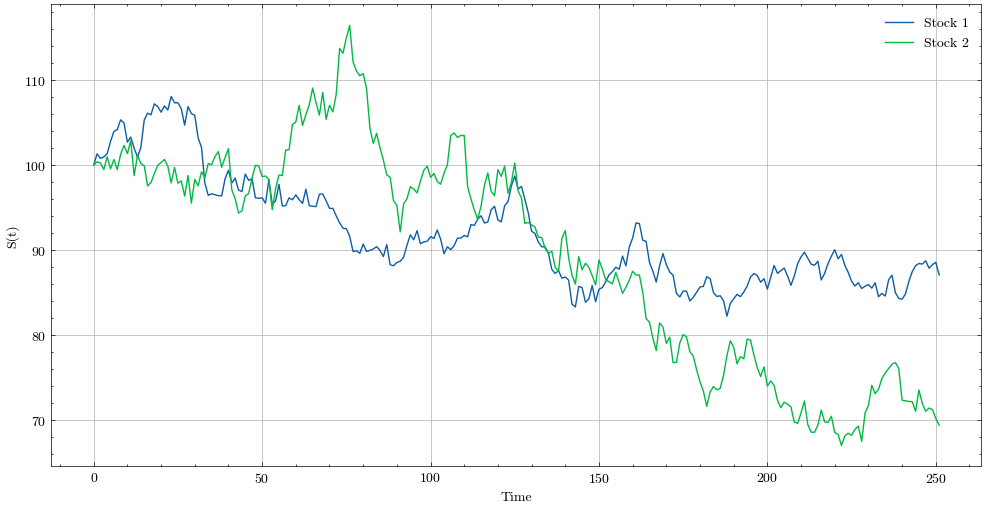

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path[:, :, 0], label='Stock 1')
plt.plot(stock_path[:, :, 1], label='Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

In [7]:
K_2 = stock_path[0, 0, 0]
K_1 = stock_path[0, 0, 1]
r = 0.0

In [8]:
gamma_f2 = bs_gamma(stock_path[0, 0, 1], K_2, jnp.asarray(r), vols[1], jnp.asarray(expiration_1))
deltas_f2 = jnp.asarray([bs_delta(stock_path[i, 0, 1], K_2, jnp.asarray(r), vols[1], jnp.asarray(expiration_1) - i * dt) for i in range(N)])
calls_f2 = jnp.asarray([european_price(stock_path[i, 0, 1], K_2, expiration_1 - i * dt, vols[1], r, dtype=jnp.float32) for i in range(N)])

In [9]:
gamma_f1 = bs_gamma(stock_path[0, 0, 0], K_1, jnp.asarray(r), vols[0], jnp.asarray(expiration_1))
deltas_f1 = jnp.asarray([bs_delta(stock_path[i, 0, 0], K_1, jnp.asarray(r), vols[0], jnp.asarray(expiration_1) - i * dt) for i in range(N)])
calls_f1 = jnp.asarray([european_price(stock_path[i, 0, 0], K_1, expiration_1 - i * dt, vols[0], r, dtype=jnp.float32) for i in range(N)])

In [10]:
spread_deltas = jnp.asarray([margrabe_deltas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_gammas = jnp.asarray([margrabe_gammas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [11]:
x_f2 = spread_gammas[0, 1] / gamma_f2
x_f1 = spread_gammas[0, 0] / gamma_f1

In [12]:
x_2 = deltas_f2 * x_f2 - spread_deltas[:, 1]
x_1 = deltas_f1 * x_f1 - spread_deltas[:, 0]

In [13]:
spread_value = jnp.asarray([margrabe(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration- i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [14]:
b = [spread_value[0] - (x_f2 * calls_f2[0] + x_f1 * calls_f1[0] + x_1[0] * stock_path[0, 0, 0] + x_2[0] * stock_path[0, 0, 1])]
vs = [spread_value[0]]
delta_1_hp = x_f1 * deltas_f1 - x_1
delta_2_hp = x_f2 * deltas_f2 - x_2

for i in range(1, N):
    vs.append(x_f2 * calls_f2[i] + x_f1 * calls_f1[i] + x_1[i - 1] * stock_path[i, 0, 0] + x_2[i - 1] * stock_path[i, 0, 1] + b[i - 1])
    b.append(vs[i] - (x_f2 * calls_f2[i] + x_f1 * calls_f1[i] + x_1[i] * stock_path[i, 0, 0] + x_2[i] * stock_path[i, 0, 1]))

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path[:, 0, 1] - stock_path[:, 0, 0], 0)

In [15]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  -8.564595


Let's now visualized how the deltas of the portfolio evolves during the experiment

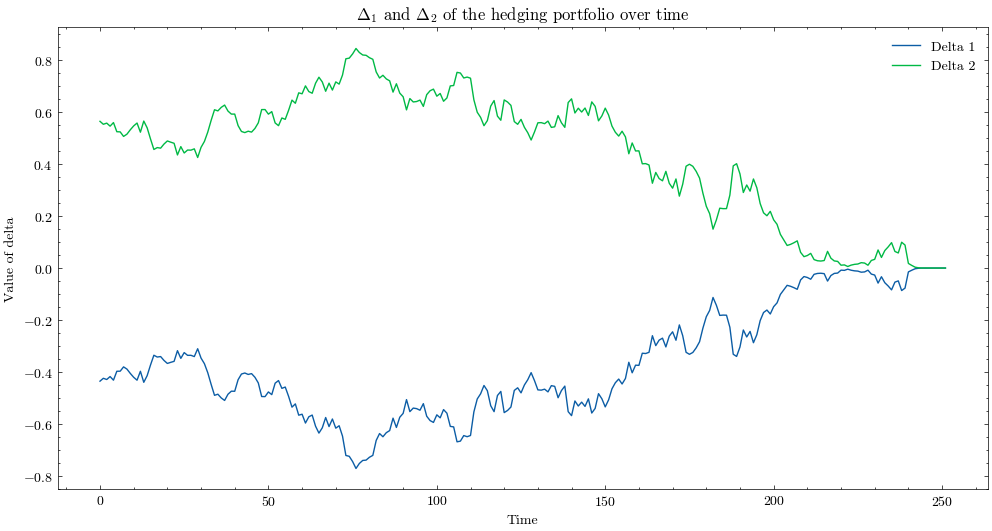

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(delta_1_hp, label='Delta 1')
plt.plot(delta_2_hp, label='Delta 2')
plt.title(r'$\Delta_1$ and $\Delta _2$ of the hedging portfolio over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.legend()
plt.show()

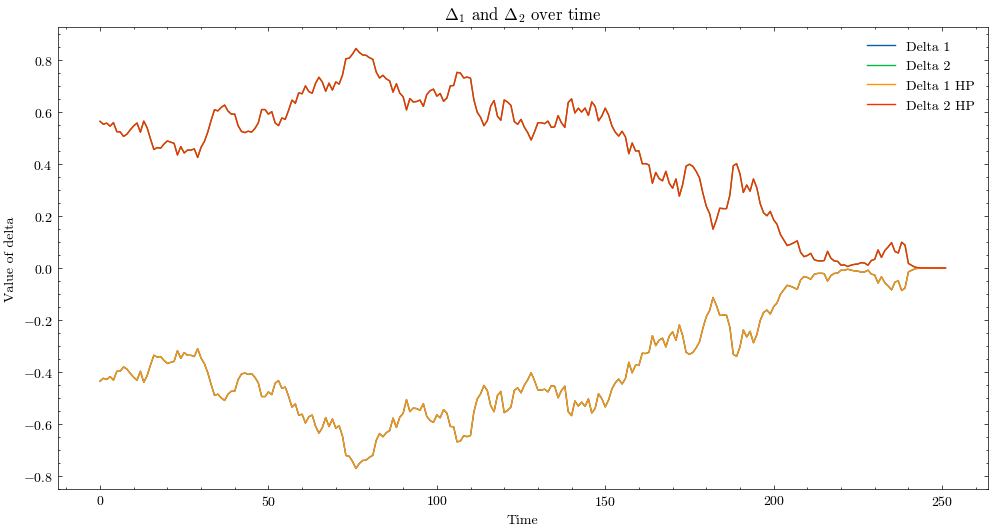

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(spread_deltas[:, 0], label='Delta 1')
plt.plot(spread_deltas[:, 1], label='Delta 2')
plt.plot(delta_1_hp, label='Delta 1 HP')
plt.plot(delta_2_hp, label='Delta 2 HP')
plt.title(r'$\Delta_1$ and $\Delta _2$ over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.legend()
plt.show()

In [18]:
cross_gammas = jnp.asarray([margrabe_cross_gamma(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
gammas = jnp.asarray([margrabe_gammas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

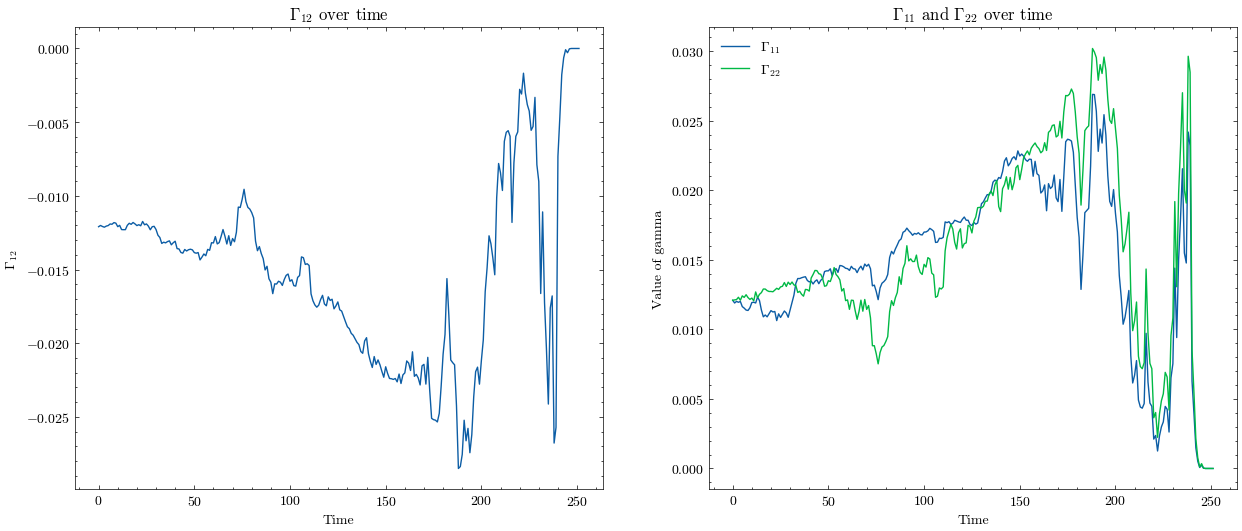

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(cross_gammas[:, 0])
axs[0].set_title(r'$\Gamma_{12}$ over time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\Gamma_{12}$')

axs[1].plot(gammas[:, 0], label=r'$\Gamma_{11}$')
axs[1].plot(gammas[:, 1], label=r'$\Gamma_{22}$')
axs[1].set_title(r'$\Gamma_{11}$ and $\Gamma_{22}$ over time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value of gamma')
axs[1].legend()

plt.show()

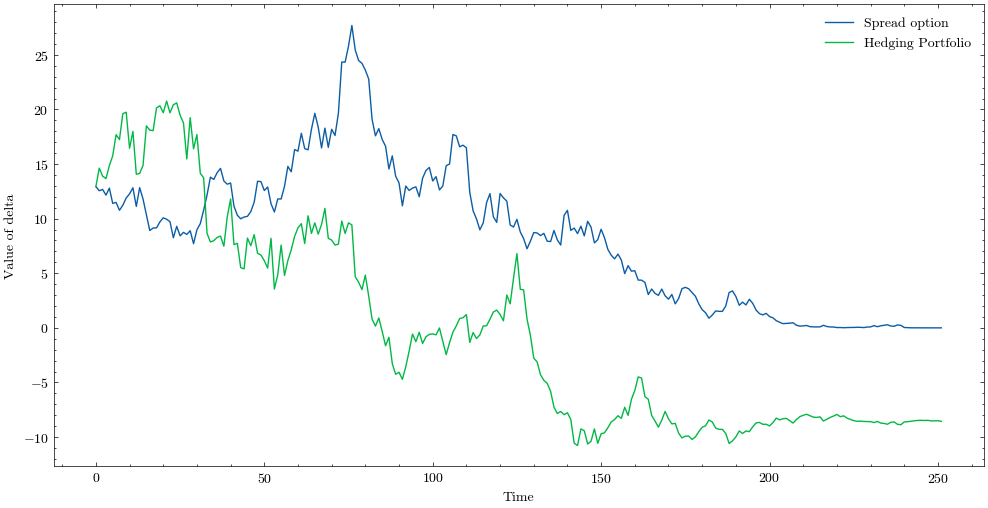

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(spread_value, label='Spread option')
plt.plot(vs, label='Hedging Portfolio')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.show()

## Multiple simulations

In [21]:
n_simulation = 1000

stock_paths = gbm.simulate_paths(SEED, expiration, N, n_simulation)

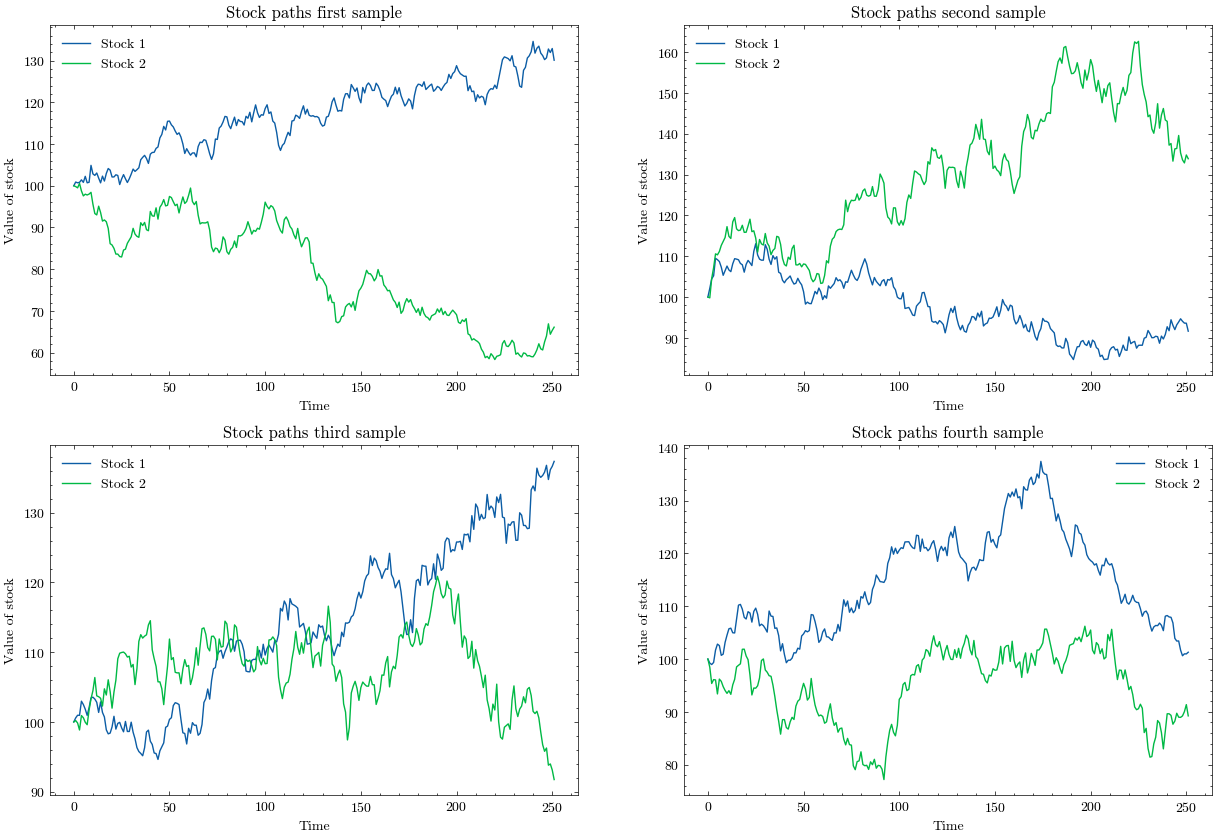

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(stock_paths[:, 0, 0], label='Stock 1')
axs[0, 0].plot(stock_paths[:, 0, 1], label='Stock 2')
axs[0, 0].set_title('Stock paths first sample')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Value of stock')
axs[0, 0].legend()

axs[0, 1].plot(stock_paths[:, 1, 0], label='Stock 1')
axs[0, 1].plot(stock_paths[:, 1, 1], label='Stock 2')
axs[0, 1].set_title('Stock paths second sample')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Value of stock')
axs[0, 1].legend()

axs[1, 0].plot(stock_paths[:, 2, 0], label='Stock 1')
axs[1, 0].plot(stock_paths[:, 2, 1], label='Stock 2')
axs[1, 0].set_title('Stock paths third sample')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Value of stock')
axs[1, 0].legend()

axs[1, 1].plot(stock_paths[:, 3, 0], label='Stock 1')
axs[1, 1].plot(stock_paths[:, 3, 1], label='Stock 2')
axs[1, 1].set_title('Stock paths fourth sample')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Value of stock')
axs[1, 1].legend()

plt.show()

## Exp.1 Hedging the Gamma initially

Let's see what is the hedging error that I get in the case I just hedge $\Gamma_{11}$ and $\Gamma_{22}$ initially, and then I redhedge the delta at each timestep

In [23]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))

In [24]:
deltas_f1 = jnp.asarray([v_delta_european(stock_paths[i, :, 0], jnp.asarray(K_1), jnp.asarray(expiration) - i * dt, jnp.asarray(vols[0]), jnp.asarray(r)) for i in range(N)])
deltas_f2 = jnp.asarray([v_delta_european(stock_paths[i, :, 1], jnp.asarray(K_2), jnp.asarray(expiration) - i * dt, jnp.asarray(vols[1]), jnp.asarray(r)) for i in range(N)])

In [26]:
calls_f1 = jnp.asarray([european_price(stock_paths[i, :, 0], K_1, expiration - i * dt, vols[0], r, dtype=jnp.float32) for i in range(N)])
calls_f2 = jnp.asarray([european_price(stock_paths[i, :, 1], K_2, expiration - i * dt, vols[1], r, dtype=jnp.float32) for i in range(N)])

In [27]:
vmap_deltas = vmap(margrabe_deltas, in_axes=(0, 0, None, None, None, None))
vmap_gammas = vmap(margrabe_gammas, in_axes=(0, 0, None, None, None, None))

In [28]:
spread_deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_gammas = jnp.asarray([vmap_gammas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [29]:
x_2 = deltas_f2 * x_f2 - spread_deltas[:, 1, :]
x_1 = deltas_f1 * x_f1 - spread_deltas[:, 0, :]

In [30]:
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

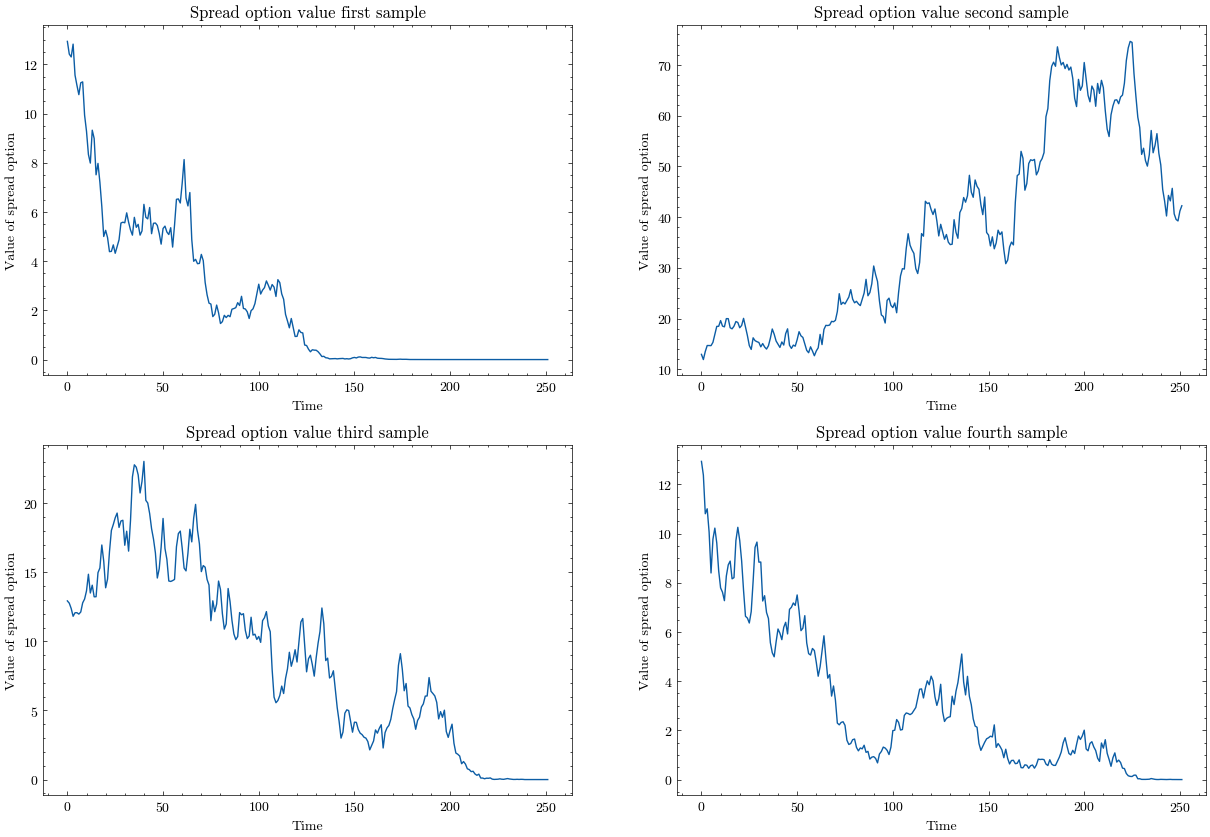

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(spread_value[:, 0])
axs[0, 0].set_title('Spread option value first sample')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Value of spread option')

axs[0, 1].plot(spread_value[:, 1])
axs[0, 1].set_title('Spread option value second sample')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Value of spread option')

axs[1, 0].plot(spread_value[:, 2])
axs[1, 0].set_title('Spread option value third sample')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Value of spread option')

axs[1, 1].plot(spread_value[:, 3])
axs[1, 1].set_title('Spread option value fourth sample')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Value of spread option')

plt.show()

In [32]:
b = jnp.asarray([spread_value[0, :] - (x_f2 * calls_f2[0, :] + x_f1 * calls_f1[0, :] + x_1[0, :] * stock_paths[0, 0, 0] + x_2[0, :] * stock_paths[0, 0, 1])])
vs = jnp.asarray([spread_value[0, :]])

for i in range(1, N):
    jnp.append(x_f2 * calls_f2[i, :] + x_f1 * calls_f1[i, :] + x_1[i - 1, :] * stock_path[i, :, 0] + x_2[i - 1, :] * stock_path[i, :, 1] + b[i - 1, :], vs)
    jnp.append(vs[i, :] - (x_f2 * calls_f2[i, :] + x_f1 * calls_f1[i, :] + x_1[i, :] * stock_path[i, :, 0] + x_2[i, :] * stock_path[i, :, 1]), b)

In [33]:
hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [34]:
jnp.mean(hedge_error[-1, :])

Array(-0.10149088, dtype=float32)

In [35]:
jnp.std(hedge_error[-1, :]) / spread_value[0, 0]

Array(1.6190732, dtype=float32)

## Exp.2 Continuosly Gamma hedging

In [52]:
v_gamma_european = vmap(gamma_european, in_axes=(0, None, None, None, None))

In [53]:
gammas_f1 = jnp.asarray([v_gamma_european(stock_paths[i, :, 0], jnp.asarray(K_1), jnp.asarray(expiration) - i * dt, jnp.asarray(vols[0]), jnp.asarray(r)) for i in range(N)])
gammas_f2 = jnp.asarray([v_gamma_european(stock_paths[i, :, 1], jnp.asarray(K_2), jnp.asarray(expiration) - i * dt, jnp.asarray(vols[1]), jnp.asarray(r)) for i in range(N)])

In [38]:
x_f1 = spread_gammas[:, 0, :] / gammas_f1
x_f2 = spread_gammas[:, 1, :] / gammas_f2

nan_maks_x_f1 = jnp.isnan(x_f1)
nan_maks_x_f2 = jnp.isnan(x_f2)

x_f1 = jnp.where(nan_maks_x_f1, 0.0, x_f1)
x_f2 = jnp.where(nan_maks_x_f2, 0.0, x_f2)

In [39]:
x_1 = deltas_f1 * x_f1 - spread_deltas[:, 0, :]
x_2 = deltas_f2 * x_f2 - spread_deltas[:, 1, :]

In [40]:
b = jnp.asarray([spread_value[0, :] - (x_f2[0, :] * calls_f2[0, :] + x_f1[0, :] * calls_f1[0, :] + x_1[0, :] * stock_paths[0, :, 0] + x_2[0, :] * stock_paths[0, :, 1])])
vs = jnp.asarray([spread_value[0, :]])

for i in range(1, N):
    jnp.append(x_f2[i, :] * calls_f2[i, :] + x_f1[i, :] * calls_f1[i, :] + x_1[i - 1, :] * stock_path[i, :, 0] + x_2[i - 1, :] * stock_path[i, :, 1] + b[i - 1, :], vs)
    jnp.append(vs[i, :] - (x_f2[i, :] * calls_f2[i, :] + x_f1[i, :] * calls_f1[i, :] + x_1[i, :] * stock_path[i, :, 0] + x_2[i, :] * stock_path[i, :, 1]), b)

In [41]:
hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [42]:
jnp.mean(hedge_error[-1, :])

Array(-0.10149088, dtype=float32)

In [43]:
jnp.std(hedge_error[-1, :]) / spread_value[0, 0]

Array(1.6190732, dtype=float32)

## Exp.3 Gamma re-hedging "once in a while"

In [55]:
gammas_f1 = jnp.asarray([v_gamma_european(stock_paths[i, :, 0], jnp.asarray(K_1), jnp.asarray(expiration) - i * dt, jnp.asarray(vols[0]), jnp.asarray(r)) for i in range(N)])
gammas_f2 = jnp.asarray([v_gamma_european(stock_paths[i, :, 1], jnp.asarray(K_2), jnp.asarray(expiration) - i * dt, jnp.asarray(vols[1]), jnp.asarray(r)) for i in range(N)])

In [56]:
x_f1 = spread_gammas[:, 0, :] / gammas_f1
x_f2 = spread_gammas[:, 1, :] / gammas_f2

nan_maks_x_f1 = jnp.isnan(x_f1)
nan_maks_x_f2 = jnp.isnan(x_f2)

x_f1 = jnp.where(nan_maks_x_f1, 0.0, x_f1)
x_f2 = jnp.where(nan_maks_x_f2, 0.0, x_f2)

In [57]:
x_1 = jnp.asarray([deltas_f1[0, :] * x_f1[0, :] - spread_deltas[0, 0, :]])
x_2 = jnp.asarray([deltas_f2[0, :] * x_f2[0, :] - spread_deltas[0, 1, :]])

In [58]:
b = jnp.asarray([spread_value[0, :] - (x_f2[0, :] * calls_f2[0, :] + x_f1[0, :] * calls_f1[0, :] + x_1[0, :] * stock_paths[0, :, 0] + x_2[0, :] * stock_paths[0, :, 1])])
vs = jnp.asarray([spread_value[0, :]])

for i in range(1, N):
    jnp.append(x_f2[i, :] * calls_f2[i, :] + x_f1[i, :] * calls_f1[i, :] + x_1[i - 1, :] * stock_path[i, :, 0] + x_2[i - 1, :] * stock_path[i, :, 1] + b[i - 1, :], vs)
    condition_1 = ~((gammas_f1[i, :] * 0.8 < spread_gammas[i, 0, :]) & (spread_gammas[i, 0, :] < gammas_f1[i, :] * 1.2))
    condition_2 = ~((gammas_f2[i, :] * 0.8 < spread_gammas[i, 1, :]) & (spread_gammas[i, 1, :] < gammas_f2[i, :] * 1.2))
    x_f1 = x_f1.at[i, :].set(jnp.where(condition_1, x_f1[i - 1, :], spread_gammas[i, 0, :] / gammas_f1[i, :]))
    x_f2 = x_f2.at[i, :].set(jnp.where(condition_2, x_f2[i - 1, :], spread_gammas[i, 1, :] / gammas_f2[i, :]))
    jnp.append(deltas_f1[i, :] * x_f1[i, :] - spread_deltas[i, 0, :], x_1)
    jnp.append(deltas_f2[i, :] * x_f2[i, :] - spread_deltas[i, 1, :], x_2)
    jnp.append(vs[i, :] - (x_f2[i, :] * calls_f2[i, :] + x_f1[i, :] * calls_f1[i, :] + x_1[i, :] * stock_path[i, :, 0] + x_2[i, :] * stock_path[i, :, 1]), b)

In [59]:
hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [60]:
jnp.mean(hedge_error[-1, :])

Array(-0.10149088, dtype=float32)

In [61]:
jnp.std(hedge_error[-1, :]) / spread_value[0, 0]

Array(1.6190732, dtype=float32)